In [1]:
%reload_ext autoreload
%autoreload 2

In [40]:
import exploring_script as es
import importlib
importlib.reload(es)
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt


from astropy.time import Time
from astropy.coordinates import SkyCoord

In [3]:
confirmed_sso = es.load_data(columns=["ssnamenr", "jd", "nid", "ra", "dec", "magpsf", "sigmapsf"])

In [4]:
rocks_names = pd.read_parquet("data/rocks_fink.parquet")
mpc_database = pd.read_parquet(
    "../data/MPC_Database/mpcorb_extended.parquet",
    columns=["Number", "Name", "Principal_desig", "Other_desigs", "a", "e", "i", "Node", "Peri", "M", "Epoch", "Orbit_type"]
)

In [5]:
start_jd = Time("2020-09-01").jd
end_jd = Time("2020-10-01").jd

In [6]:
exp_paper_data = confirmed_sso[(confirmed_sso["jd"] > start_jd) & (confirmed_sso["jd"] < end_jd)]

In [7]:
mpc_in_fink, fink_not_in_mpc = es.mpc_crossmatch(mpc_database, pd.Series(exp_paper_data["ssnamenr"].unique()))

In [8]:
orbfit_limit_point=6
tw=15


is_detectable = (
        exp_paper_data.sort_values("jd")
        .groupby("ssnamenr")
        .agg(nb_det=("ra", len), is_in_tw=("jd", lambda x: np.all(np.diff(x) <= tw)))
        .reset_index()
    )

In [9]:
exp_paper_data = exp_paper_data.merge(is_detectable, on="ssnamenr")

In [10]:
exp_paper_data_detectable = exp_paper_data[(exp_paper_data["nb_det"] >= orbfit_limit_point) & (exp_paper_data["is_in_tw"])]

In [11]:
mpc_in_detectable, detectable_not_in_mpc = es.mpc_crossmatch(mpc_database, pd.Series(exp_paper_data_detectable["ssnamenr"].unique()))

In [12]:
mpc_in_fink["Orbit_type"].value_counts()

MBA                                           80594
Jupiter Trojan                                 2065
Hungaria                                       1596
Phocaea                                        1127
Object with perihelion distance < 1.665 AU      695
Hilda                                           349
Amor                                            111
Apollo                                           87
Distant Object                                   29
Aten                                             13
Name: Orbit_type, dtype: int64

In [13]:
mpc_in_detectable["Orbit_type"].value_counts()

MBA                                           42237
Jupiter Trojan                                 1058
Hungaria                                        788
Phocaea                                         635
Object with perihelion distance < 1.665 AU      407
Hilda                                           189
Amor                                             53
Apollo                                           49
Distant Object                                   12
Aten                                              5
Name: Orbit_type, dtype: int64

In [14]:
mpc_in_detectable

,Number,Name,Principal_desig,Other_desigs,a,e,i,Node,Peri,M,Epoch,Orbit_type
33,(34),Circe,A855 GA,1965 JL,2.686888,0.106587,5.49740,184.33198,330.04966,80.66508,2460000.5,MBA
44,(45),Eugenia,A857 MA,1941 BN,2.720880,0.083354,6.60508,147.59158,87.54349,346.55692,2460000.5,MBA
50,(51),Nemausa,A858 BA,1949 HC1,2.364919,0.067404,9.97939,175.95499,1.69084,116.27059,2460000.5,MBA
61,(62),Erato,A860 RD,A906 BE,3.130603,0.168109,2.23647,125.12030,277.48090,127.94379,2460000.5,MBA
66,(67),Asia,A861 HA,None,2.422194,0.184575,6.02929,202.38775,107.06734,284.59770,2460000.5,MBA
...,...,...,...,...,...,...,...,...,...,...,...,...
1088217,None,None,2017 YG13,2015 EU4,2.289755,0.234933,4.04789,53.75587,330.70343,232.09054,2460000.5,MBA
1091374,None,None,2018 BA18,None,2.732153,0.236757,8.51407,93.65058,250.96625,205.93107,2460000.5,MBA
1111028,None,None,2019 AS55,None,1.932107,0.113588,17.87981,303.87141,56.44723,318.19537,2460000.5,Hungaria
1115074,None,None,2019 GP45,None,2.583391,0.288735,10.49456,16.31149,329.24792,223.04968,2460000.5,MBA


In [15]:
bft_data = pd.read_parquet("../data/BFT_Miriade/ssoBFT-latest.parquet", 
                columns=["sso_id", "sso_number", "sso_name", "sso_type", "sso_class"])

In [16]:
rocks_names["ast_number"] = rocks_names["ast_number"].fillna(-1).astype(int).astype(str)

In [17]:
def get_label(x):
        if x[0] == "MB":
            if x[1] in ["Middle", "Outer", "Inner"]:
                return x[0]
            else:
                return x[1]
        elif x[0] == "NEA":
            return x[1]
        else:
            return x[0]

def merge_bft(data):
    merge = (data
            .merge(rocks_names, left_on="ssnamenr", right_on="ast_number")
            .merge(bft_data, left_on="ast_name", right_on="sso_name")
            )
    merge["class_alt"] = (
        merge["sso_class"].str.split(">").map(lambda x: get_label(x))
    )

    return merge

In [75]:
exp_with_bft = merge_bft(exp_paper_data_detectable)

In [76]:
exp_with_bft["class_alt"].value_counts()

MB              618812
Trojan           14382
Hungaria         10869
Phocaea           7546
Mars-Crosser      7061
Hilda             2794
Cybele            2772
Apollo             707
Amor               600
KBO                 90
Aten                66
Centaur             39
Name: class_alt, dtype: int64

# KBO analysis

In [77]:
kbo_class = exp_with_bft[exp_with_bft["class_alt"] == "KBO"]
kbo_class["iso_time"] = Time(kbo_class["jd"], format="jd").iso

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [78]:
kbo_diff_time = kbo_class.sort_values("jd").groupby("sso_name").agg(
    time=("iso_time", list),
    diff_time=("jd", lambda x: list(np.diff(x))),
    diff_time_start=("jd", lambda x: list(x)[1] - list(x)[0] if len(list(x)) > 1 else np.nan)
).explode("diff_time")

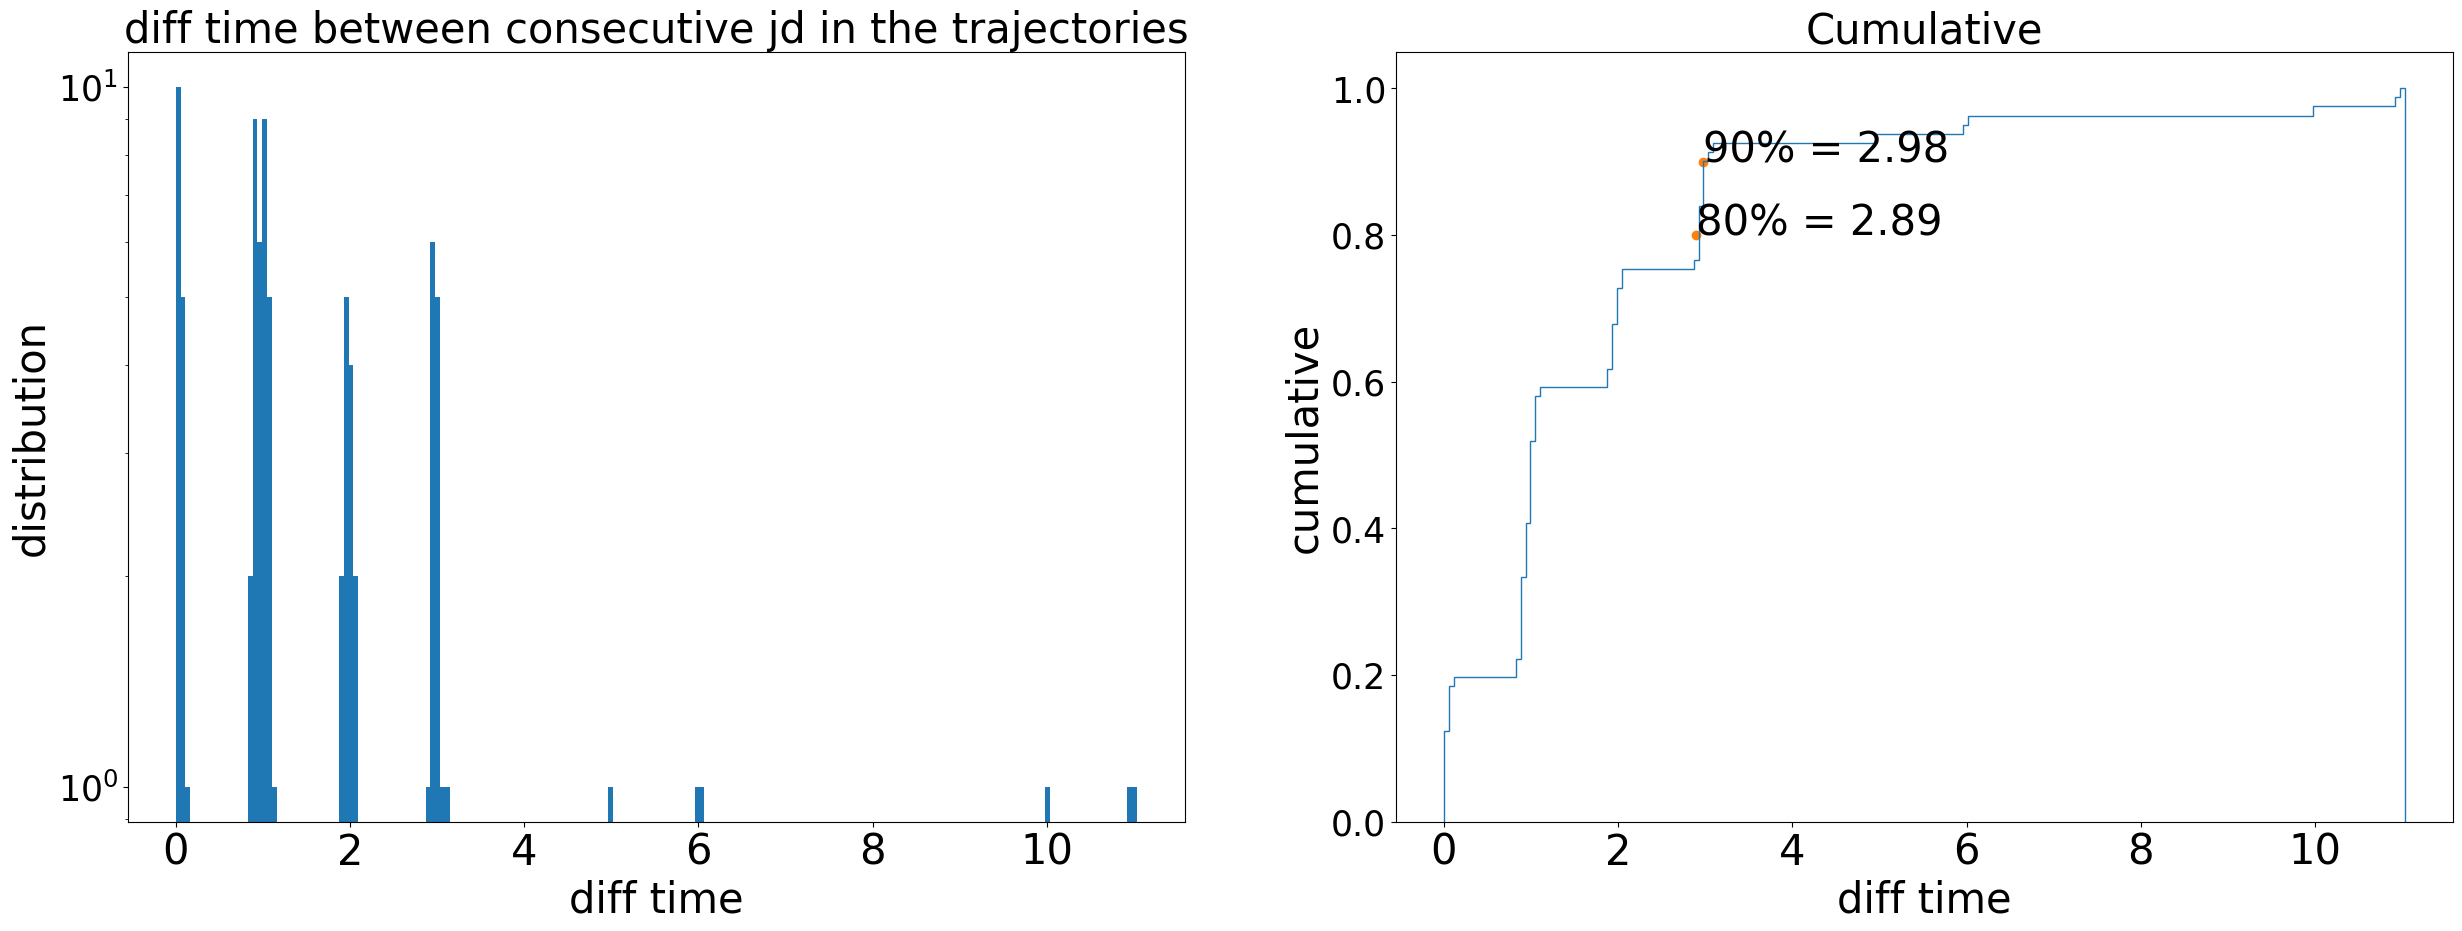

In [79]:
es.plot_hist_and_cdf(
    kbo_diff_time["diff_time"],
    None,
    "diff time between consecutive jd in the trajectories",
    "diff time",
    "distribution",
    None,
    "Cumulative",
    "diff time",
    "cumulative"
)

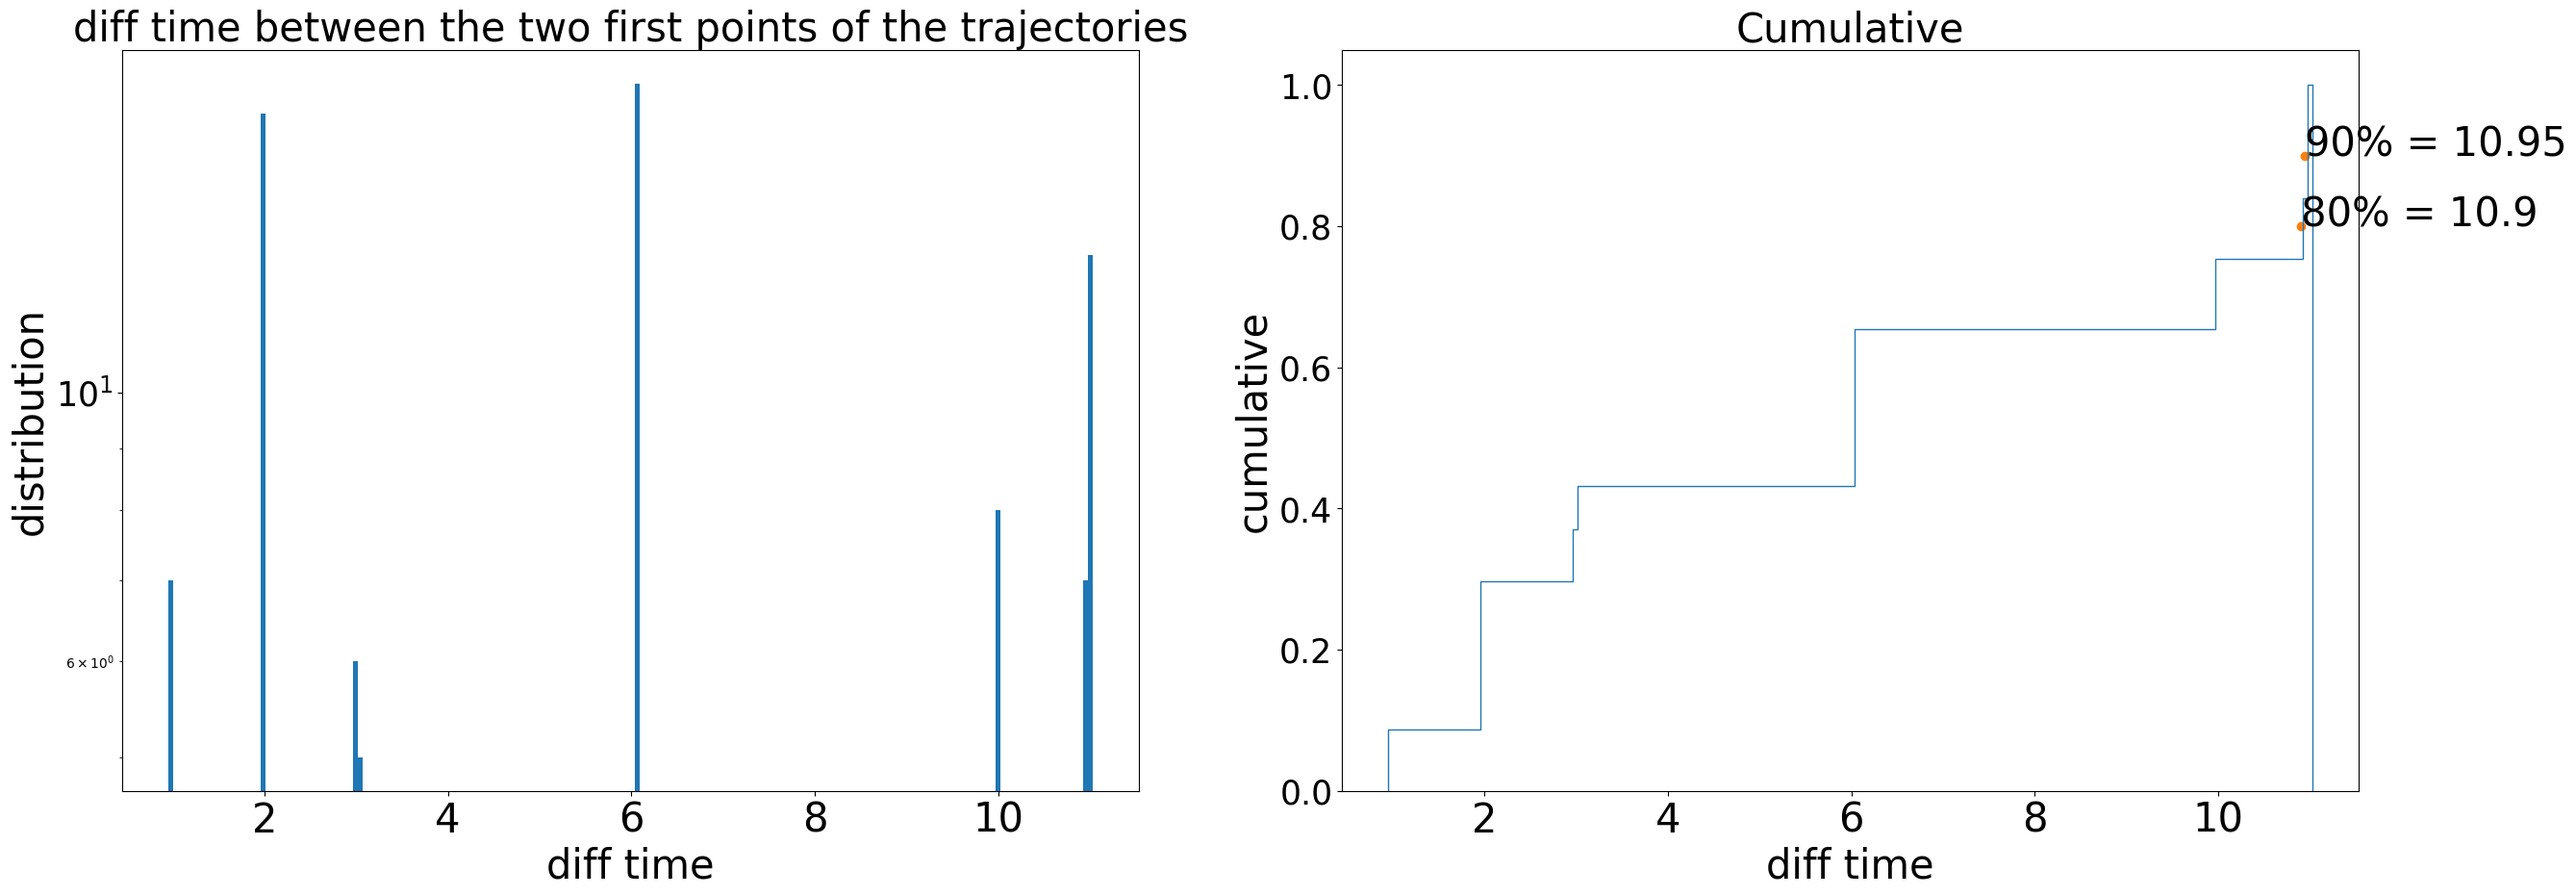

In [80]:
es.plot_hist_and_cdf(
    kbo_diff_time["diff_time_start"],
    None,
    "diff time between the two first points of the trajectories",
    "diff time",
    "distribution",
    None,
    "Cumulative",
    "diff time",
    "cumulative"
)

In [81]:
kbo_name = kbo_class[(kbo_class["jd"] >= Time("2020-09-04").jd) & (kbo_class["jd"] < Time("2020-09-05").jd)]["ssnamenr"]

In [82]:
Time(kbo_class.sort_values("jd").groupby("ssnamenr").agg(
    first_jd=("jd", lambda x: list(x)[0])
)["first_jd"], format="jd").iso

array(['2020-09-04 09:36:18.999', '2020-09-04 08:52:21.000',
       '2020-09-16 11:39:19.996', '2020-09-16 11:38:40.001',
       '2020-09-15 09:29:32.997', '2020-09-04 09:04:47.004',
       '2020-09-15 10:08:14.004', '2020-09-04 08:09:17.001',
       '2020-09-16 11:48:47.998'], dtype='<U23')

In [83]:
first_night = pd.read_parquet("../../save_ff_output_kbo_neo_issue/2020-09-04/trajectory_df.parquet")

In [84]:
kbo_first_night_assoc = first_night[first_night["trajectory_id"].isin(first_night[first_night["ssnamenr"].isin(kbo_name)]["trajectory_id"])]

In [85]:
merge_bft(kbo_first_night_assoc)

,ra,dec,jd,nid,fid,magpsf,sigmapsf,candid,not_updated,last_assoc_date,...,ssnamenr,assoc_tag,ast_name,ast_number,sso_id,sso_number,sso_name,sso_type,sso_class,class_alt
0,26.744931,-1.229936,2.459095e+06,1340,1,18.094423,0.094016,1340498484515015021,True,2020-09-02,...,10546,N,Nakanomakoto,10546,Nakanomakoto,10546.0,Nakanomakoto,Asteroid,MB>Inner,MB
1,23.507748,12.372524,2.459095e+06,1340,1,18.908697,0.194976,1340495193815015001,True,2020-09-02,...,60351,N,2000 AG87,60351,2000_AG87,60351.0,2000 AG87,Asteroid,MB>Inner,MB
2,26.591834,-1.549407,2.459097e+06,1342,2,18.594046,0.088013,1342400214515015018,True,2020-09-04,...,136199,N,Eris,136199,Eris,136199.0,Eris,Dwarf Planet,KBO>Detached,KBO
3,23.113685,12.083184,2.459097e+06,1342,2,19.411676,0.196562,1342378323815015009,True,2020-09-04,...,44594,N,1999 OX3,44594,1999_OX3,44594.0,1999 OX3,Asteroid,KBO>SDO,KBO


In [86]:
bft_first_night = merge_bft(first_night)
bft_first_night["class_alt"].value_counts()

MB              45803
Phocaea           717
Mars-Crosser      658
Hungaria          620
Trojan            520
Cybele            239
Hilda             179
Apollo             74
Amor               53
Aten                4
KBO                 2
Name: class_alt, dtype: int64

In [87]:
bft_first_night[bft_first_night["class_alt"] == "KBO"]["trajectory_id"]

48758    24532
48769    24638
Name: trajectory_id, dtype: int64

In [88]:
first_kbo_assoc = bft_first_night[bft_first_night["trajectory_id"] == 24532]

In [89]:
coord_first_kbo = SkyCoord(first_kbo_assoc["ra"].values, first_kbo_assoc["dec"].values, unit="deg")

In [90]:
coord_first_kbo[0].separation(coord_first_kbo[1])

<Angle 0.3542407 deg>

In [91]:
path_save_ff = "../../save_ff_output_kbo_neo_issue/*"

In [92]:
for path in np.sort(glob.glob(path_save_ff)):
    print(path)
    pdf_night = pd.read_parquet(f"{path}/trajectory_df.parquet")
    kbo_first_night_assoc = pdf_night[pdf_night["trajectory_id"].isin(pdf_night[pdf_night["ssnamenr"].isin(kbo_name)]["trajectory_id"])]
    print(merge_bft(kbo_first_night_assoc).sort_values("trajectory_id")[["sso_id", "trajectory_id", "assoc_tag", "class_alt"]])
    print()
    print()

../../save_ff_output_kbo_neo_issue/2020-09-01
Empty DataFrame
Columns: [sso_id, trajectory_id, assoc_tag, class_alt]
Index: []


../../save_ff_output_kbo_neo_issue/2020-09-02
Empty DataFrame
Columns: [sso_id, trajectory_id, assoc_tag, class_alt]
Index: []


../../save_ff_output_kbo_neo_issue/2020-09-03
Empty DataFrame
Columns: [sso_id, trajectory_id, assoc_tag, class_alt]
Index: []


../../save_ff_output_kbo_neo_issue/2020-09-04
         sso_id  trajectory_id assoc_tag class_alt
0  Nakanomakoto          24532         N        MB
2          Eris          24532         N       KBO
1     2000_AG87          24638         N        MB
3      1999_OX3          24638         N       KBO


../../save_ff_output_kbo_neo_issue/2020-09-05
         sso_id  trajectory_id assoc_tag class_alt
0  Nakanomakoto          24532         N        MB
1          Eris          24532         N       KBO
2     2000_AG87          24638         N        MB
3      1999_OX3          24638         N       KBO


../../s

# NEO analysis

In [93]:
neo_class = ["Apollo", "Amor", "Aten"]

neo_class = exp_with_bft[exp_with_bft["class_alt"].isin(neo_class)]
neo_class["iso_time"] = Time(neo_class["jd"], format="jd").iso

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [94]:
neo_names = neo_class["ssnamenr"].unique()

In [95]:
Time(neo_class.sort_values("jd").groupby("ssnamenr").agg(
    first_jd=("jd", lambda x: list(x)[0])
)["first_jd"], format="jd").iso

array(['2020-09-01 10:40:07.003', '2020-09-01 04:09:45.000',
       '2020-09-17 12:03:25.001', '2020-09-02 05:29:10.003',
       '2020-09-20 09:03:37.002', '2020-09-16 09:23:20.000',
       '2020-09-15 10:10:57.999', '2020-09-01 09:16:10.998',
       '2020-09-20 09:58:17.999', '2020-09-02 09:20:20.003',
       '2020-09-02 09:27:08.001', '2020-09-01 09:20:59.997',
       '2020-09-17 09:16:56.004', '2020-09-15 10:28:05.002',
       '2020-09-18 11:40:40.996', '2020-09-15 07:04:30.996',
       '2020-09-19 09:07:05.002', '2020-09-01 08:59:11.996',
       '2020-09-15 10:19:49.999', '2020-09-18 08:04:10.998',
       '2020-09-03 03:26:37.000', '2020-09-01 09:16:10.998',
       '2020-09-03 10:06:06.002', '2020-09-17 07:40:58.999',
       '2020-09-15 10:14:25.999', '2020-09-03 10:15:02.002',
       '2020-09-16 11:07:38.004', '2020-09-12 09:28:30.003',
       '2020-09-01 08:38:38.999', '2020-09-12 09:29:09.997',
       '2020-09-04 03:51:05.999', '2020-09-01 11:06:39.001',
       '2020-09-05 06:32

In [96]:
for path in np.sort(glob.glob(path_save_ff)):
    print(path)
    pdf_night = pd.read_parquet(f"{path}/trajectory_df.parquet")
    neo_first_night_assoc = pdf_night[pdf_night["trajectory_id"].isin(pdf_night[pdf_night["ssnamenr"].isin(neo_names)]["trajectory_id"])]
    m = merge_bft(neo_first_night_assoc).sort_values("trajectory_id")[["sso_id", "trajectory_id", "assoc_tag", "class_alt", "jd"]]
    m.sort_values("jd").groupby("sso_id").agg(
        traj_ids=("trajectory_id", "unique"),
        diff_jd=("jd", lambda x: list(np.diff(x))),
        tags=("assoc_tag", list),
        nb_point=("trajectory_id", len)
    ).style.format(precision=2)

../../save_ff_output_kbo_neo_issue/2020-09-01
../../save_ff_output_kbo_neo_issue/2020-09-02
../../save_ff_output_kbo_neo_issue/2020-09-03
../../save_ff_output_kbo_neo_issue/2020-09-04
../../save_ff_output_kbo_neo_issue/2020-09-05
../../save_ff_output_kbo_neo_issue/2020-09-06
../../save_ff_output_kbo_neo_issue/2020-09-07
../../save_ff_output_kbo_neo_issue/2020-09-08
../../save_ff_output_kbo_neo_issue/2020-09-09
../../save_ff_output_kbo_neo_issue/2020-09-10
../../save_ff_output_kbo_neo_issue/2020-09-11
../../save_ff_output_kbo_neo_issue/2020-09-12
../../save_ff_output_kbo_neo_issue/2020-09-13
../../save_ff_output_kbo_neo_issue/2020-09-14
../../save_ff_output_kbo_neo_issue/2020-09-15
../../save_ff_output_kbo_neo_issue/2020-09-16
../../save_ff_output_kbo_neo_issue/2020-09-17


In [97]:
m.sort_values("jd").groupby("sso_id").agg(
        traj_ids=("trajectory_id", "unique"),
        diff_jd=("jd", lambda x: list(np.diff(x))),
        tags=("assoc_tag", list),
        nb_point=("trajectory_id", len)
    ).style.format(precision=2)

,traj_ids,diff_jd,tags,nb_point
sso_id,,,,
1978_UW4,[19575 67276],"[0.0, 0.1192013998515904, 0.0]","['I', 'I', 'I', 'I']",4
1981_EA5,[93100],[],['N'],1
1981_ED43,[12998],[],['A'],1
1990_MF,[22411 42220 93100 90149 90151],"[9.90163189964369, 0.08888890035450459, 0.9283912000246346, 0.0, 1.9438310000114143, 0.0]","['N', 'I', 'I', 'N', 'N', 'N', 'N']",7
1990_MU,[1577],"[0.0424885000102222, 1.9832406998611987, 0.029374999925494194]","['I', 'I', 'T', 'T']",4
1990_SB,[2651],"[0.011307800188660622, 2.903113500215113, 0.10226849978789687]","['I', 'I', 'T', 'T']",4
1990_SL11,[88064 26059 48907],"[0.0, 1.96835649991408]","['A', 'A', 'A']",3
1991_EA1,[66324],[0.04236110020428896],"['T', 'T']",2
1992_PK1,[26646],[],['N'],1
